In [0]:
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'




In [0]:

labels_url= 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

resp = requests.get(labels_url) 
labels = {int(key): value for key, value in resp.json().items()}



In [0]:

vgg16 = models.vgg16(pretrained=True)
vgg16.aux_logits=False

vgg16.eval();
print(vgg16)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:

IMAGE_URL = "https://specials-images.forbesimg.com/imageserve/5e342eb1f133f400076b43d9/960x0.jpg?fit=scale"
response = requests.get(IMAGE_URL)
img = Image.open(io.BytesIO(response.content))
print(img)
#img.show()


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x640 at 0x7F80896E5630>


In [0]:

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([            
 transforms.Resize(256),                   
 transforms.CenterCrop(224),               
 transforms.ToTensor()] )

img_tensor = transform(img) 
img_tensor = img_tensor.unsqueeze(0)
img_variable = Variable(img_tensor, requires_grad=True)
img_variable.requires_grad = True



In [0]:

prediction = vgg16.forward(img_variable) 
pred_index = prediction.data.numpy().argmax() 
print ('{}: {}'.format(pred_index, labels[pred_index]) )
prediction_var= Variable( torch.Tensor(prediction) )

"""
#probability of prediction
output_probs = F.softmax(prediction, dim=1)
x_pred_prob =  round((torch.max(prediction, 1)[0][0]) * 100,4)
print(x_pred_prob)
"""

true_class =   2 
epsilon=0.02

target = Variable(torch.LongTensor([true_class]), requires_grad=False)




2: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias


In [0]:

loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(prediction, target)
loss_cal.backward(retain_graph=True)
data_grad = img_variable.grad.data



In [0]:

sign_data_gradient_matrix = data_grad.sign()
attacked_img = img_variable + epsilon*sign_data_gradient_matrix
attacked_img = torch.clamp(attacked_img, 0, 1)


In [0]:

# New prediction
new_prediction = vgg16(attacked_img)
new_pred_index = new_prediction.data.numpy().argmax() 
print("NEW PREDICTION {}: {}".format(new_pred_index, labels[new_pred_index]) )

"""
x_adv_pred = labels[torch.max(new_prediction.data, 1)[1][0]]    
op_adv_probs = F.softmax(output_adv, dim=1)                 
perturb_img_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      
"""




NEW PREDICTION 3: tiger shark, Galeocerdo cuvieri


'\nx_adv_pred = labels[torch.max(new_prediction.data, 1)[1][0]]    \nop_adv_probs = F.softmax(output_adv, dim=1)                 \nperturb_img_prob =  round((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      \n'

In [0]:

def plot_all(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()
    x = np.transpose( x , (1,2,0)) 
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()#reverse of normalization op
    x_adv = np.transpose( x_adv , (1,2,0))  
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Original Image', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Image (misclassified)', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n".format(clean_pred), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n".format(adv_pred), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()






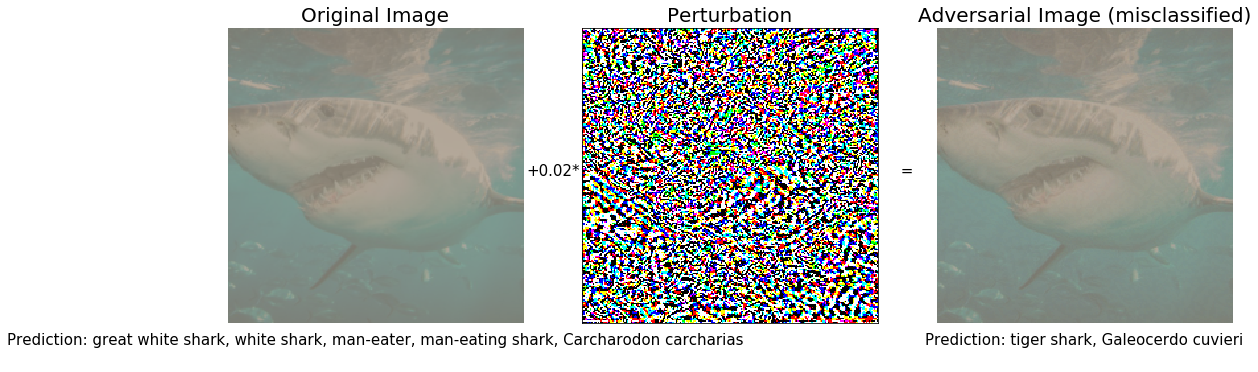

In [0]:

plot_all( img_tensor, attacked_img, sign_data_gradient_matrix, epsilon, labels[pred_index], labels[new_pred_index], 0,0 )